## **Deep Learning Made Easy**

----

**Important:** This notebook was developed by <a href="https://github.com/Yangyangii">Jinhyeok Yang</a> and some modifications have been done by <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>. It is about <a href="https://arxiv.org/pdf/1411.1784.pdf">Conditional GAN (CGAN)</a>.

<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)


##Conditional Generative Adversarial Networks (CGANs)
----


Generative adversarial networks (GANs), as originally proposed in <a href="https://arxiv.org/abs/1406.2661">[Goodfellow et al. 2014]</a>, are unconditioned generative models. In other words, there is no control on modes of the data being generated. In a conditioned generative model, we can condition the model on additional information and thus directing the data generation
process. Such conditioning could be, for instance, class labels or data from other modalities.

<br>

Hence, this is the innovation behind conditional GANs (CGANs), an extended version of the original GAN, where they  condition both the discriminator and the generator by feeding each with class labels. 

<br>


<img src="https://drive.google.com/uc?id=1lfn4Y4HRSUSri5eCbu-rnNY9CKiczvV3" alt="Drawing" width="400"/>

Source: <a href="https://dl.acm.org/doi/fullHtml/10.1145/3439723">[Wang et al. 2022]</a>.






##Encoding
----

Note that $y$ (class label) is normally encoded inside the generator and discriminator before being concatenated with the encoded $z$ and encoded $x$.

<br>

<img src="https://drive.google.com/uc?id=1ilNf6yb4lcYff7DC48sQjzqruJdZl5Ek" alt="Drawing" width="400"/>

Source: <a href="https://arxiv.org/pdf/1411.1784.pdf">CGAN article</a>.

<br>

The extra encoded $y$ data, allows CGAN to
handle unimodal image datasets but also multimodal datasets which contains labelled
image data with their associated user-generated metadata, i.e., in particular user-tags, which brings
GANs over to the area of multimodal data generation.

<br>

###Multimodal deep learning?

Multimodal deep learning aims at building models that can process and link information using various modalities (image, video, text, audio, body gestures,...). Multimodal learning helps to understand and analyse better when various senses are engaged in the processing of information. 




##Loss Function
----

The CGAN's loss function (two-player minimax game) is a bit different of the one in the original GAN article, as shown below.



\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x|y)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z|y)))\big]\end{align}

<br>

Compare this to loss function of theoriginal GAN article:



\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}



In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [2]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Integer and One-hot Encoding
----

In integer encoding, we assing to each category (class) an integer value ('red' = 0; blue = '1'; ...). Since the integer values have a natural ordered relationship between each other, some machine learning (ML) algorithms may infer that this order is relevant (2 > 1) and this can influence their outcomes.

<br>


In order to avoid this problem, in one-hot encoding, each category is encoded so that there is a single high (1) bit and all the others low (0). 

In [3]:
data = ['forest', 'ocean', 'river', 'river', 'forest', 'forest', 'hill']
values = array(data)
print("Categorical data:", values)
# integer encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print("Integer encoding:", integer_encoded)
# binary encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print("One-hot encoding: \n {}".format(onehot_encoded))
# get back last
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[6, :])])
print("Last:", inverted)

Categorical data: ['forest' 'ocean' 'river' 'river' 'forest' 'forest' 'hill']
Integer encoding: [0 2 3 3 0 0 1]
One-hot encoding: 
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Last: ['hill']


In [4]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [5]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

##Discriminator and Generator
----

In this notebook, the discriminator and generator are both multilayer perceptron (MLP) networks and not convolutional neural networks (CNNs). Hence, there are no convolutional layers.

In [6]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x, c):        
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        return y_

In [7]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, condition_size=10, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size+condition_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.layer(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [8]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

In [10]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [11]:
batch_size = 64
condition_size = 10

In [12]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [13]:
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [14]:
max_epoch = 30 # need more than 100 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [15]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [16]:
if not os.path.exists('samples'):
    os.makedirs('samples')

In [17]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        #print('No one-hot:', y[0])
        y = to_onehot(y).to(DEVICE)
        #print('Yes one-hot:', y[0])
        x_outputs = D(x, y)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, y), y)
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        #D.zero_grad()
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = criterion(z_outputs, D_labels)

            #G.zero_grad()
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/30, Step: 0, D Loss: 1.3889656066894531, G Loss: 0.6697888374328613
Epoch: 0/30, Step: 500, D Loss: 1.2005103826522827, G Loss: 1.118541955947876
Epoch: 1/30, Step: 1000, D Loss: 1.1270325183868408, G Loss: 0.8678293824195862
Epoch: 1/30, Step: 1500, D Loss: 1.1444590091705322, G Loss: 1.6532553434371948
Epoch: 2/30, Step: 2000, D Loss: 1.1889454126358032, G Loss: 0.8188260793685913
Epoch: 2/30, Step: 2500, D Loss: 1.2533116340637207, G Loss: 1.4847115278244019
Epoch: 3/30, Step: 3000, D Loss: 1.3084630966186523, G Loss: 0.8786370754241943
Epoch: 3/30, Step: 3500, D Loss: 1.2172118425369263, G Loss: 0.8719804286956787
Epoch: 4/30, Step: 4000, D Loss: 1.285605549812317, G Loss: 1.1076548099517822
Epoch: 4/30, Step: 4500, D Loss: 1.1583123207092285, G Loss: 0.8417552709579468
Epoch: 5/30, Step: 5000, D Loss: 1.3338994979858398, G Loss: 0.6003626585006714
Epoch: 5/30, Step: 5500, D Loss: 1.3492647409439087, G Loss: 0.8433938026428223
Epoch: 6/30, Step: 6000, D Loss: 1.25159072875

##Output of the Generator
----

We can now see the output of the generator.

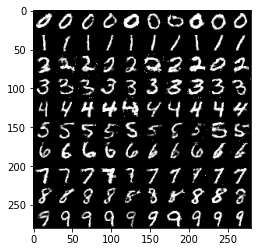

In [18]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [19]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [20]:
# Saving parameters
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_c.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_c.pth.tar')